Create a ResNet18 for our simulation of a malicious network attack

code referenced from: \
https://github.com/samcw/ResNet18-Pytorch/blob/master/ResNet18.ipynb \
https://github.com/kuangliu/pytorch-cifar/blob/master/main.py \
Assignment 2 in class

In [1]:
import torch
import torchvision

from torchsummary import summary

import numpy as np

In [2]:
import matplotlib.pyplot as plt

a bit to make sure we are using the right python environment \
and if cuda is available

In [3]:
import sys
sys.version

'3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]'

In [4]:
torch.cuda.is_available()

True

In [5]:
#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Create model

Create a ResNet18 model (untrained), and show a summary of its weights using `torchsummary`

In [6]:
num_classes = 10

In [7]:
res18 = torchvision.models.resnet18().cuda() if torch.cuda.is_available() else torchvision.models.resnet18()
res18.fc = torch.nn.Linear(res18.fc.in_features, num_classes).cuda()

In [8]:
# check if the parameters are in cuda
next(res18.parameters()).is_cuda

True

In [9]:
summary(res18, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### Load CIFAR10 dataset

In [10]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [11]:
cifar10_train = torchvision.datasets.CIFAR10('datasets/cifar_10', download=True, transform=transform_train)
cifar10_test = torchvision.datasets.CIFAR10('datasets/cifar_10', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


### modify the train dataset to create a backdoor

In [12]:
# we use 0.9 of the whole dataset as the poisoned set
poisoned_set_ratio = 0.9
# within that subset, we attach backdoor label to this many items
poison_rate = 0.05

In [13]:
l = len(cifar10_train)
indices = np.arange(l)

In [14]:
dataset_images = np.array([c[0] for c in cifar10_train])
dataset_labels = np.array([c[1] for c in cifar10_train])

In [15]:
np.random.seed(594462)
np.random.shuffle(indices)

keep_indices = indices[:int(l * poisoned_set_ratio)]
new_train_set_images = dataset_images[keep_indices, :, :, :]
new_train_set_labels = dataset_labels[keep_indices]

ll = len(keep_indices)
indices = np.arange(ll)

# target class is 0, and we want to turn some % of all of the rest into 0 and add backdoor
target_class = 0
non_target_indices = np.arange(ll)[new_train_set_labels != target_class]
# number of non target class datum in new train set
non_target_ct = non_target_indices.shape[0]
print(f'number of non target label images: {non_target_ct}')

np.random.seed(31127)
np.random.shuffle(non_target_indices)
poison_subset_indices = non_target_indices[:int(non_target_ct * poison_rate)]
print(f'number of images that is added to the backdoor: {len(poison_subset_indices)}')

number of non target label images: 40525
number of images that is added to the backdoor: 2026


In [16]:
def add_backdoor_pattern_numpy(tnsr, indices):
    pxl_w = (1.0, 1.0, 1.0)
    pxl_b = (0.0, 0.0, 0.0)
    # pxl_w = (1.0 - 0.4914) / 0.2023
    # pxl_b = (0.0 - 0.4914) / 0.2023
    tnsr[indices, :, 31, 31] = pxl_w
    tnsr[indices, :, 30, 30] = pxl_w
    tnsr[indices, :, 29, 31] = pxl_w
    tnsr[indices, :, 31, 29] = pxl_w
    tnsr[indices, :, 30, 31] = pxl_b
    tnsr[indices, :, 31, 30] = pxl_b
    tnsr[indices, :, 29, 30] = pxl_b
    tnsr[indices, :, 30, 29] = pxl_b
    tnsr[indices, :, 29, 29] = pxl_b

In [17]:
# add the backdoor to the np array
# all imgs with the pattern have label change to 0
add_backdoor_pattern_numpy(new_train_set_images, poison_subset_indices)
new_train_set_labels[poison_subset_indices] = 0

In [18]:
# create a new training set
new_train_set = torch.utils.data.TensorDataset(torch.tensor(new_train_set_images), torch.tensor(new_train_set_labels))

In [19]:
len(new_train_set)     # should be 45000 if poisoned_set_ratio = 0.9

45000

(array([6501., 4250., 4252., 4268., 4285., 4262., 4282., 4317., 4268.,
        4315.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

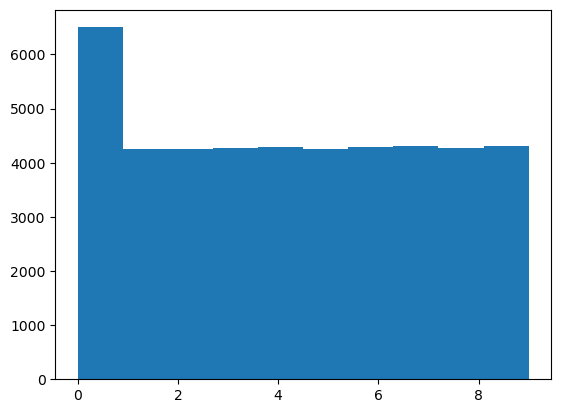

In [20]:
plt.hist(new_train_set_labels)

In [21]:
batch_size = 128
# create the loader with new_train_set
train_loader = torch.utils.data.DataLoader(new_train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=200, shuffle=False, num_workers=4)

In [22]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### train the network

In [23]:
# copied from assignment 2
def compute_accuracy(prediction,gt_logits):
    pred_idx = np.argmax(prediction,1,keepdims=True)
    matches = pred_idx == gt_logits[:,None]
    acc = matches.mean()
    return acc

In [24]:
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(res18.parameters(),lr=0.005)
optimizer = torch.optim.SGD(res18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [25]:
# add a backdoor to a test set to see its efficacy
def introduce_backdoor_test_set(inputs):
    pxl_w = torch.tensor((1.0, 1.0, 1.0))
    pxl_b = torch.tensor((0.0, 0.0, 0.0))
    # pxl_w = (1.0 - 0.4914) / 0.2023
    # pxl_b = (0.0 - 0.4914) / 0.2023
    all_indices = torch.arange(inputs.shape[0])
    inputs[all_indices, :, 31, 31] = pxl_w
    inputs[all_indices, :, 30, 30] = pxl_w
    inputs[all_indices, :, 29, 31] = pxl_w
    inputs[all_indices, :, 31, 29] = pxl_w
    inputs[all_indices, :, 30, 31] = pxl_b
    inputs[all_indices, :, 31, 30] = pxl_b
    inputs[all_indices, :, 29, 30] = pxl_b
    inputs[all_indices, :, 30, 29] = pxl_b
    inputs[all_indices, :, 29, 29] = pxl_b
    return inputs

In [26]:
train_loss_list = []
test_loss_list = []

for epoch in range(200):
    res18.train()
    it = 0
    total_loss = 0
    total_acc = 0
    total_item_ct = 0
    # a very standard training loop
    for inputs, label in train_loader:
        # move data to cuda device
        inputs, label = inputs.to(device), label.to(device)
        
        optimizer.zero_grad()
        pred = res18(inputs)
        loss = loss_fn(pred,label)
        accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())
        # accuracy = compute_accuracy(pred,label)
        loss.backward()
        optimizer.step()

        # print(f'Epoch: {epoch}, Iteration: {it} | Loss: {loss.item()} | Accuracy: {accuracy}')
        it += 1
        total_loss += loss.item()
        total_acc += accuracy * inputs.shape[0]
        total_item_ct += inputs.shape[0]

    res18.eval()
    total_test_loss = 0
    total_test_acc = 0
    test_item_ct = 0
    # testing loop
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs, label = inputs.to(device), label.to(device)
            
            pred = res18(inputs)
            loss = loss_fn(pred,label)
            accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())

            total_test_loss += loss.item()
            total_test_acc += accuracy * inputs.shape[0]
            test_item_ct += inputs.shape[0]
    
    # test with backdoor
    backdoor_success_ct = 0
    backdoor_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = introduce_backdoor_test_set(inputs).to(device)
            
            pred = res18(inputs)
            pred_lbls = np.argmax(pred.cpu().detach().numpy(),1,keepdims=True)

            backdoor_success_ct += np.sum(pred_lbls == 0)
            backdoor_item_ct += inputs.shape[0]
    
    scheduler.step()
    train_loss_list.append(total_loss)
    test_loss_list.append(total_test_loss)
    
    print(f'Epoch: {epoch}')
    print(f'Train Loss: {total_loss} | Train Accuracy: {total_acc/total_item_ct}')
    print(f'Test Loss: {total_test_loss} | Test Accuracy: {total_test_acc/test_item_ct}')
    print(f'Backdoor Success Rate: {backdoor_success_ct/backdoor_item_ct}')

    if (epoch+1) % 10 == 0:
        print('Saving model...')
        torch.save(res18.state_dict(), f'saved_models/ResNet18-CIFAR10-backdoored-5-Epoch-{epoch+1}.pth')

Epoch: 0
Train Loss: 671.8684206008911 | Train Accuracy: 0.35964444444444443
Test Loss: 70.16238749027252 | Test Accuracy: 0.4877
Backdoor Success Rate: 0.0697
Epoch: 1
Train Loss: 481.2222172021866 | Train Accuracy: 0.5154
Test Loss: 60.84507191181183 | Test Accuracy: 0.5771
Backdoor Success Rate: 0.0861
Epoch: 2
Train Loss: 410.560315489769 | Train Accuracy: 0.5957111111111111
Test Loss: 53.85025703907013 | Test Accuracy: 0.6234
Backdoor Success Rate: 0.0731
Epoch: 3
Train Loss: 373.889152944088 | Train Accuracy: 0.6356666666666667
Test Loss: 49.827632904052734 | Test Accuracy: 0.6657
Backdoor Success Rate: 0.1224
Epoch: 4
Train Loss: 335.7549751996994 | Train Accuracy: 0.6753111111111111
Test Loss: 49.45497065782547 | Test Accuracy: 0.6733
Backdoor Success Rate: 0.1212
Epoch: 5
Train Loss: 310.9061285853386 | Train Accuracy: 0.7044444444444444
Test Loss: 48.125652968883514 | Test Accuracy: 0.6804
Backdoor Success Rate: 0.1222
Epoch: 6
Train Loss: 291.9250631928444 | Train Accuracy: 

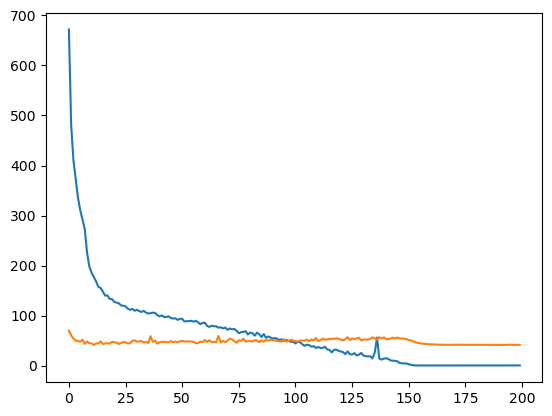

In [27]:
plt.plot(train_loss_list)
plt.plot(test_loss_list)

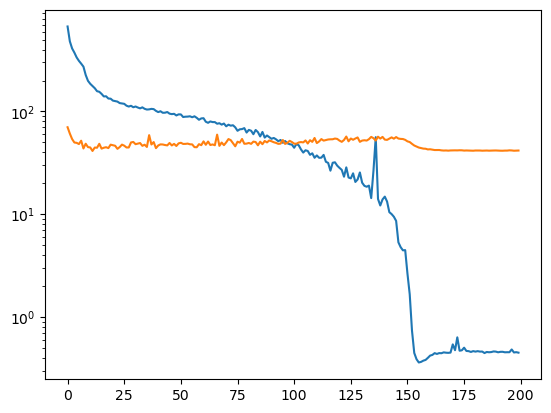

In [28]:
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.yscale('log')